In [1]:
import cv2
import torch
import numpy as np
import pygame
from IPython.display import display, Image, clear_output
import os
import threading


pygame 2.6.0 (SDL 2.28.4, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [9]:
# Initialize pygame for sound
pygame.init()
pygame.mixer.init()

# Path to the alarm sound
path_alarm = (r"alarm.wav")
pygame.mixer.music.load(path_alarm)

In [4]:
# Load the YOLOv5 model
try:
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

Using cache found in C:\Users\manje/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-7-22 Python-3.10.6 torch-2.1.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [5]:
# Define target classes for detection
target_classes = ['car', 'bus', 'truck', 'person']

# Initialize variables for counting photos
first_detection=False
count = 0
number_of_photos = 3

# List to store points for polygon (ROI)
pts = []

In [6]:
# Function to check if a point is inside a polygon
def inside_polygon(point, polygon):
    result = cv2.pointPolygonTest(polygon, (point[0], point[1]), False)
    return result >= 0

# Function to preprocess the frame
def preprocess(img):
    height, width = img.shape[:2]
    ratio = height / width
    img = cv2.resize(img, (640, int(640 * ratio)))
    return img

In [7]:
# Initialize video capture
video_path = "video.mp4"
cap = cv2.VideoCapture(video_path)

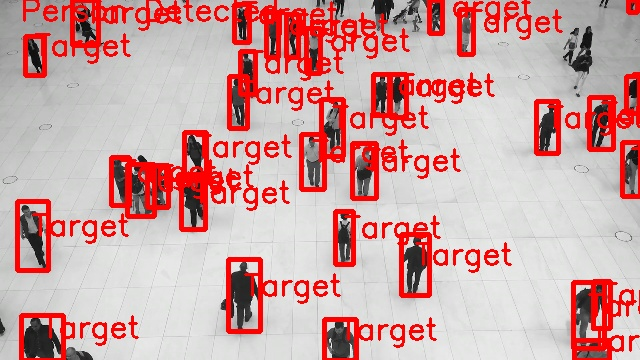

In [10]:

# Initialize video capture
video_path = "video.mp4"
cap = cv2.VideoCapture(video_path)
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frames")
            break

        frame_detected = frame.copy()
        frame = preprocess(frame)

        if model:
            results = model(frame)

        # detection and processing logic
            for index, row in results.pandas().xyxy[0].iterrows():
                center_x, center_y = None, None
                
                if row['name'] in target_classes:
                    name = str(row['name'])
                    x1, y1 = int(row['xmin']), int(row['ymin'])
                    x2, y2 = int(row['xmax']), int(row['ymax'])

                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

                    
                    if not first_detection:
                        
                        first_detection=True    
                        detected_photo_path = os.path.join("Detected Photos", f"detected{count}.jpg")
                        cv2.imwrite(detected_photo_path, frame_detected)
                        print(f"Saved image: {detected_photo_path}")
                        count += 1
                                    
                    # Play alarm
                    
                    if not pygame.mixer.music.get_busy():
                        pygame.mixer.music.play()
                        
                            
                    cv2.putText(frame, "Target", (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    cv2.putText(frame, "Person Detected", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
                
        # Display the frame
        _, jpeg = cv2.imencode('.jpg', frame)
        display(Image(data=jpeg.tobytes()))
        clear_output(wait=True)
    
        # Check for a key press to break the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    if 'cap' in locals() and cap.isOpened():
        cap.release()
    pygame.quit()
